# Exploratory Data Analysis (EDA)

This notebook explores user–item interaction data for a recommender system task.
The goal of the EDA is to understand user behavior, item characteristics, temporal
patterns and interaction structures in order to motivate subsequent modeling
choices (collaborative filtering, sequence modeling, pattern mining, etc.).



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.dates as mdates

from pathlib import Path
from collections import Counter


In [ ]:
sns.set_theme(style="whitegrid", context="talk") 

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Arial", "Liberation Sans"],  # 会自动用可用的
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 20,
    "axes.titlepad": 10,
})



In [3]:
DATA_DIR = Path("challenge_dataset/input")
DATA_ROOT_DIR = Path("challenge_dataset")
search = pd.read_parquet(DATA_DIR / "search_query.parquet")
add = pd.read_parquet(DATA_DIR / "add_to_cart.parquet")
remove = pd.read_parquet(DATA_DIR / "remove_from_cart.parquet")
buy = pd.read_parquet(DATA_DIR / "product_buy.parquet")
products = pd.read_parquet(DATA_ROOT_DIR / "product_properties.parquet")

relevant_clients = np.load(DATA_DIR / "relevant_clients.npy")


In [4]:
datasets = {
    "search": search,
    "add_to_cart": add,
    "remove_from_cart": remove,
    "buy": buy,
    "products": products,
}

for name, df in datasets.items():
    print(f"{name:15s} | rows={len(df):>10,} | cols={df.shape[1]}")
    print(f"Columns: {list(df.columns)}\n")


search          | rows=10,218,831 | cols=3
Columns: ['client_id', 'timestamp', 'query']

add_to_cart     | rows= 5,674,064 | cols=3
Columns: ['client_id', 'timestamp', 'sku']

remove_from_cart | rows= 1,937,170 | cols=3
Columns: ['client_id', 'timestamp', 'sku']

buy             | rows= 1,775,394 | cols=3
Columns: ['client_id', 'timestamp', 'sku']

products        | rows= 1,260,365 | cols=4
Columns: ['sku', 'category', 'price', 'name']



Here I load the four behavioral logs (search, add-to-cart, remove-from-cart, buy) and the product catalog, along with the relevant_clients list used by the challenge evaluation. This establishes the full behavioral funnel and the available item side information. A critical point is that many downstream statistics should be recomputed on relevant_clients to match the evaluation population and avoid reporting metrics on users that are not scored.

In [5]:
USER_COL = "client_id"
ITEM_COL = "sku"
TIME_COL = "timestamp"
QUERY_COL = "query"


In [6]:
def missing_ratio(df):
    return (df.isna().mean() * 100).sort_values(ascending=False)

missing_ratio(products)


sku         0.0
category    0.0
price       0.0
name        0.0
dtype: float64

I compute missing-value rates for key product fields (SKU, category, price, name). The absence of missing values suggests that item side features are reliably available and can be used for cold-start mitigation and feature-based reranking. However, “no missing values” does not guarantee quality—price outliers and category granularity still require validation.

In [7]:
for name, df in datasets.items():
    print(name, df.duplicated().sum())


search 576286
add_to_cart 107117
remove_from_cart 104293
buy 283545
products 0


I measure the number of fully duplicated rows in each event log as a data-quality and semantics check. A particularly high duplicate rate in purchases can indicate either logging artifacts (needing deduplication) or meaningful multiplicity (e.g., repeated purchases or quantity-like behavior). This choice directly impacts model targets and feature engineering, so duplicates should be handled carefully (e.g., keep counts as weights vs. hard dedup).

### User & Item Statistics

In [8]:
users = set(search[USER_COL]) \
      | set(add[USER_COL]) \
      | set(remove[USER_COL]) \
      | set(buy[USER_COL])

items = set(add[ITEM_COL]) \
      | set(remove[ITEM_COL]) \
      | set(buy[ITEM_COL])

print("Unique users:", len(users))
print("Unique items:", len(items))


Unique users: 2832878
Unique items: 1260365


I compute the total number of unique users and unique items across all interaction types to quantify the “universe size” of the recommendation problem. The large user/item cardinalities imply a highly sparse interaction matrix and strong long-tail effects, which makes dense co-occurrence methods less effective and increases the importance of embedding-based retrieval, negative sampling, and time-aware validation.

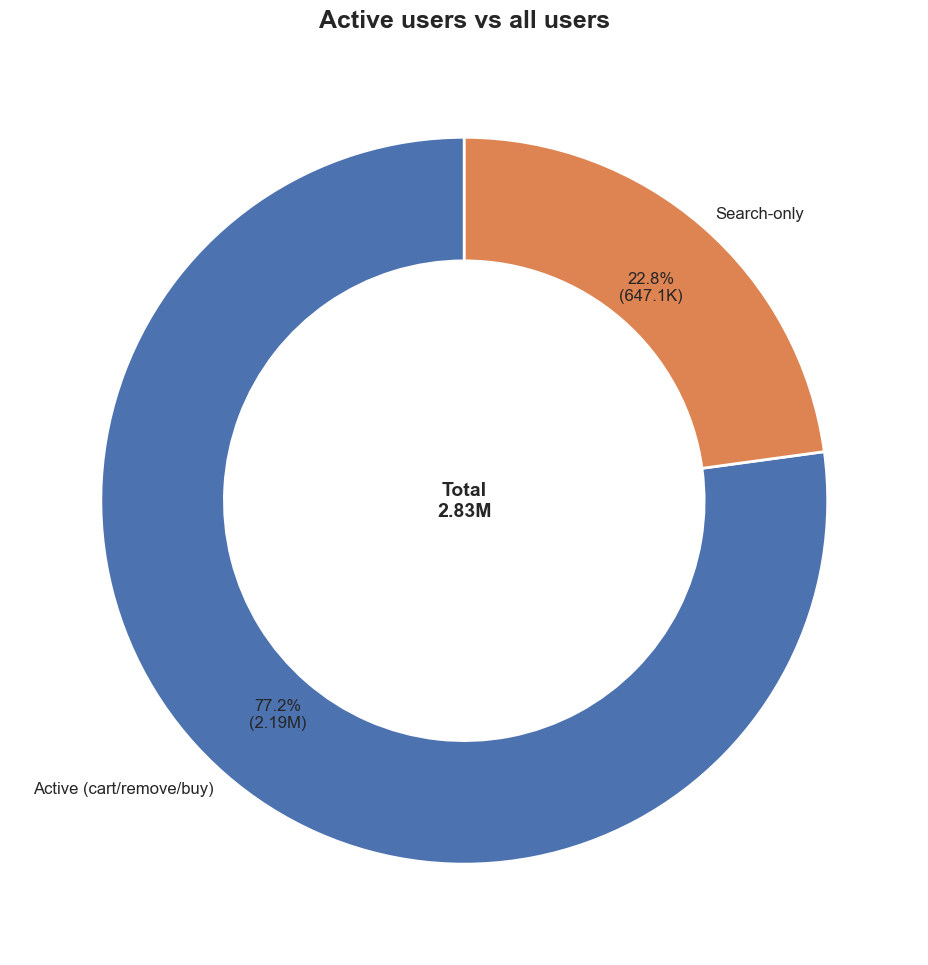

In [ ]:

all_users_full = pd.Index(
    pd.concat([search[USER_COL], add[USER_COL], remove[USER_COL], buy[USER_COL]]).unique(),
    name=USER_COL
)

active_users = pd.Index(
    pd.concat([add[USER_COL], remove[USER_COL], buy[USER_COL]]).unique(),
    name=USER_COL
)

n_all = len(all_users_full)
n_active = len(active_users)
n_inactive = n_all - n_active  


sns.set_theme(style="whitegrid", context="talk")

sizes = [n_active, n_inactive]
labels = ["Active (cart/remove/buy)", "Search-only"]
total = sum(sizes)

def fmt_num(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.2f}M"
    if x >= 1_000:
        return f"{x/1000:.1f}K"
    return str(x)

def make_autopct(vals):
    def _autopct(pct):
        val = int(round(pct/100.0 * sum(vals)))
        return f"{pct:.1f}%\n({fmt_num(val)})"
    return _autopct

fig, ax = plt.subplots(figsize=(15, 10))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    pctdistance=0.78,
    labeldistance=1.05,
    wedgeprops=dict(width=0.34, edgecolor="white", linewidth=2),
    textprops=dict(fontsize=12),
)

ax.text(
    0, 0,
    f"Total\n{fmt_num(total)}",
    ha="center", va="center",
    fontsize=14, fontweight="bold"
)

ax.set_title("Active users vs all users", pad=14, fontweight="bold")

plt.tight_layout()
plt.show()


I segment users into (1) those who only search and (2) those who perform deeper funnel actions (cart/remove/buy), and visualize their proportions. This highlights that a large fraction of users may show only weak intent (search-only), suggesting that modeling should separately address “stage transition” (search → cart/buy) and that query-driven retrieval might be essential for early-funnel users.

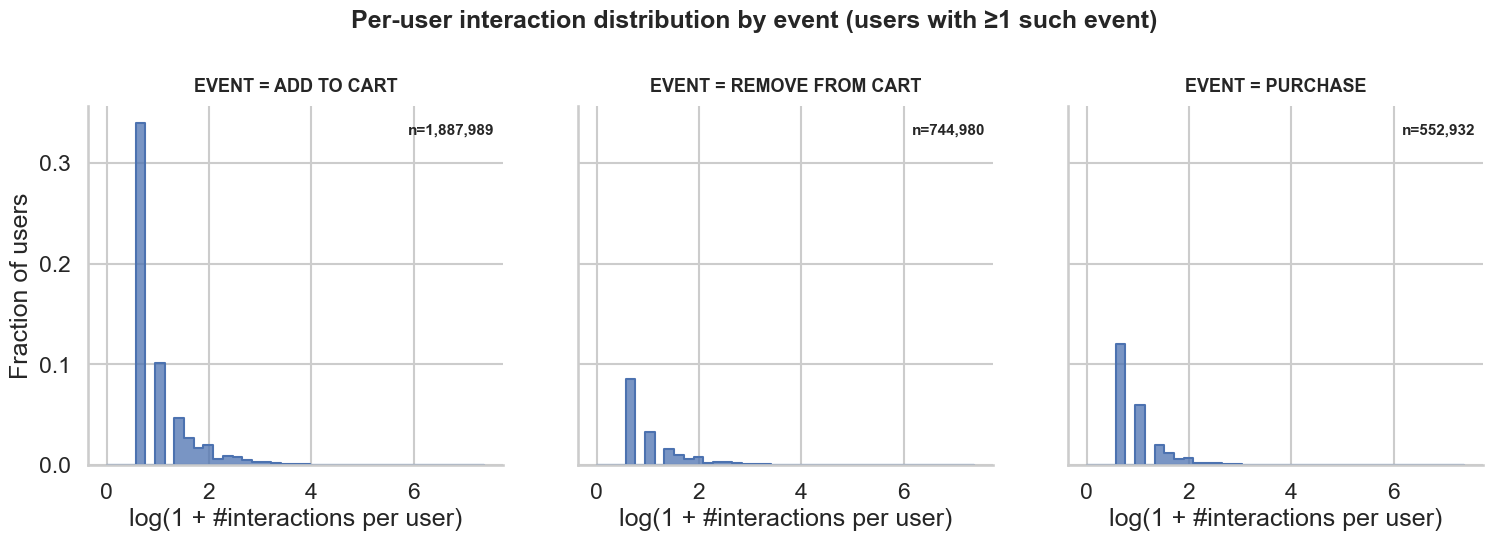

In [ ]:
def per_user_counts_nonzero(df, event_name):
    return (
        df.groupby(USER_COL)
          .size()
          .rename("n")
          .reset_index()
          .assign(event=event_name)
    )

counts_long = pd.concat([
    per_user_counts_nonzero(add, "add_to_cart"),
    per_user_counts_nonzero(remove, "remove_from_cart"),
    per_user_counts_nonzero(buy, "purchase"),
], ignore_index=True)

event_display = {
    "add_to_cart": "ADD TO CART",
    "remove_from_cart": "REMOVE FROM CART",
    "purchase": "PURCHASE",
}
counts_long["event"] = counts_long["event"].map(event_display)

counts_long["log_n"] = np.log1p(counts_long["n"])

max_log = counts_long["log_n"].max()
bins = np.linspace(0, max_log, 40) 

g = sns.displot(
    data=counts_long,
    x="log_n",
    col="event",
    col_wrap=3,
    bins=bins,
    common_bins=True,
    height=4.2,
    aspect=1.5,
    element="step",
    fill=True,  
    stat="probability", 
    linewidth=1.5,
)

g.set_axis_labels("log(1 + #interactions per user)", "Fraction of users")
g.set_titles("EVENT = {col_name}", size=13, weight="bold")
g.fig.subplots_adjust(top=0.82, wspace=0.18)
g.fig.suptitle(
    "Per-user interaction distribution by event (users with ≥1 such event)",
    fontsize=18,
    fontweight="bold"
)


for ax, (ev, sub) in zip(g.axes.flat, counts_long.groupby("event")):
    ax.text(
        0.98, 0.95,
        f"n={sub.shape[0]:,}",
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=11,
        fontweight="bold",
    )

g.fig.set_size_inches(15, 6)
sns.despine()
plt.show()


I visualize how many cart/removal/purchase events each user generates, using a log transform to handle heavy tails. The distributions show strong heterogeneity: most users have few events, while a small minority generate many. This implies that training data is dominated by heavy users unless we apply weighting/stratified sampling, and that user segmentation can be meaningful.

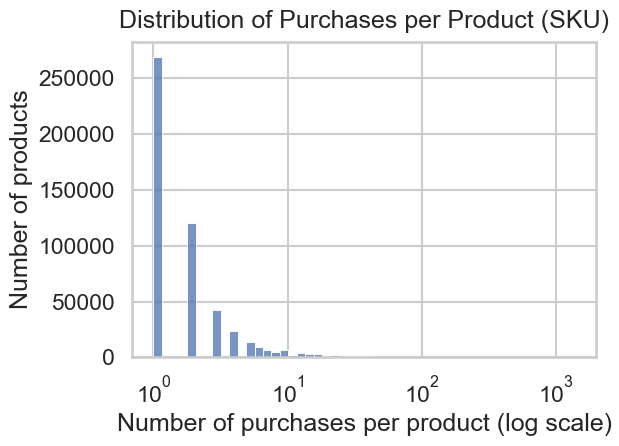

In [11]:
# Interactions per item (SKU)
item_event_counts = buy[ITEM_COL].value_counts()

plt.figure()
sns.histplot(
    item_event_counts,
    bins=50,
    log_scale=True,
)

plt.title("Distribution of Purchases per Product (SKU)")
plt.xlabel("Number of purchases per product (log scale)")
plt.ylabel("Number of products")

plt.tight_layout()
plt.show()


I analyze the distribution of purchase counts per item to quantify item popularity skew. The long-tail shape indicates that a small set of items accounts for a large portion of purchases, while most items are rarely bought. This suggests popularity bias risks (models over-recommending head items) and motivates evaluation that accounts for novelty/diversity or long-tail coverage.

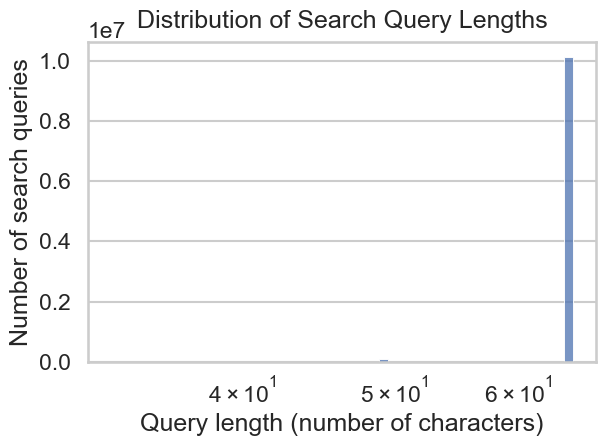

In [12]:
# Search query length distribution
search["query_length"] = search[QUERY_COL].str.len()

plt.figure()
sns.histplot(
    search["query_length"],
    bins=50,
    log_scale=True,
)

plt.title("Distribution of Search Query Lengths")
plt.xlabel("Query length (number of characters)")
plt.ylabel("Number of search queries")

plt.tight_layout()
plt.show()


I compute the length distribution of search queries to check whether query text contains meaningful natural language information. If query lengths cluster around a constant value, it suggests anonymization or hashed identifiers rather than free-form text, which changes how query features should be modeled (categorical ID statistics rather than NLP-based embeddings).

/var/folders/y_/zp8w9l2s0772ngfxwvj2s7f80000gn/T/ipykernel_73330/1093760024.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  query_conv = conv.groupby("query_length_bin")["converted"].mean()


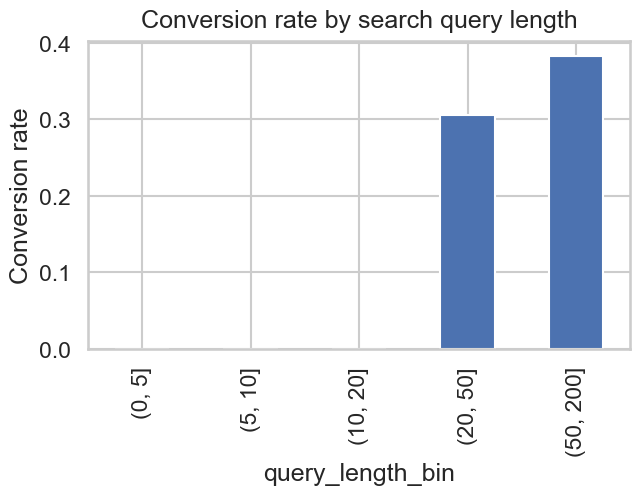

In [13]:
search["query_length_bin"] = pd.cut(search["query_length"], bins=[0,5,10,20,50,200])
conv = (
    search.merge(buy[[USER_COL]].drop_duplicates(), on=USER_COL, how="left", indicator=True)
)
conv["converted"] = (conv["_merge"] == "both").astype(int)

query_conv = conv.groupby("query_length_bin")["converted"].mean()

query_conv.plot(kind="bar", figsize=(7,4))
plt.title("Conversion rate by search query length")
plt.ylabel("Conversion rate")
plt.show()


I relate query-length bins to a conversion proxy (whether the user ever purchased). This is primarily a user-type signal rather than a strict query-level conversion estimate, because it ignores temporal proximity and sessions (it does not enforce “search then buy within a time window”). The result is useful as a sanity check, but should not be over-interpreted as causal “query effectiveness.”

In [14]:
search["query_length"].describe()
search["query_length"].value_counts().head(20)


query_length
65    10131974
49       86823
33          34
Name: count, dtype: int64

I summarize query lengths numerically to validate the earlier suspicion about anonymization. A dominant single length strongly indicates that query strings are standardized IDs. Consequently, query_length is not a meaningful semantic feature; instead, we should focus on query frequency, user coverage, and query→item interaction patterns.

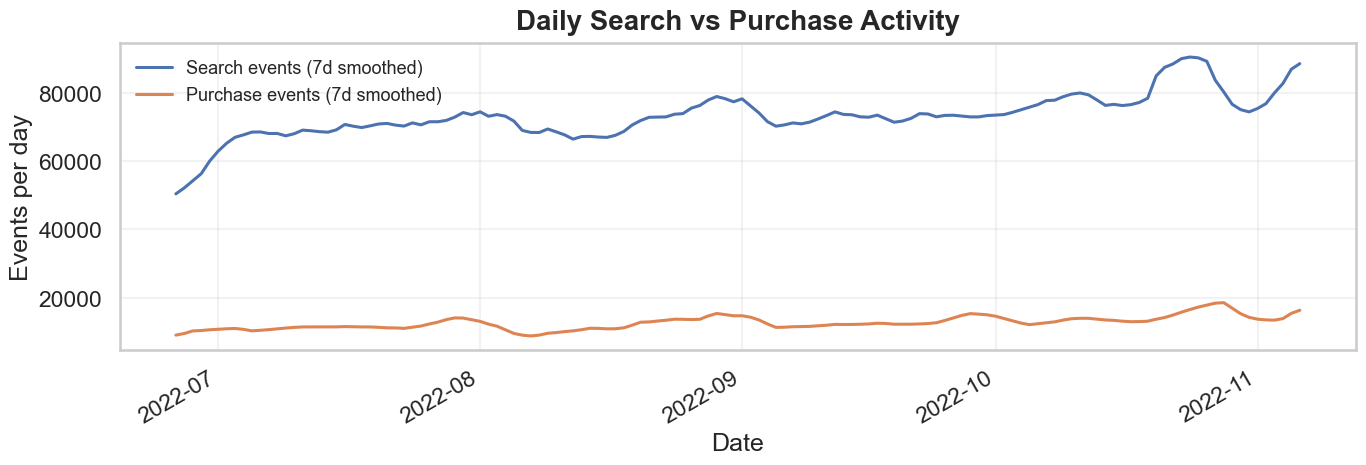

In [ ]:
search_daily = (
    search
    .set_index(TIME_COL)
    .resample("D")
    .size()
)

buy_daily = (
    buy
    .set_index(TIME_COL)
    .resample("D")
    .size()
)

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(14, 5))

smooth_search = search_daily.rolling(7, center=True).mean()
smooth_buy = buy_daily.rolling(7, center=True).mean()

plt.plot(
    search_daily.index,
    smooth_search,
    label="Search events (7d smoothed)",
    linewidth=2.2,
)

plt.plot(
    buy_daily.index,
    smooth_buy,
    label="Purchase events (7d smoothed)",
    linewidth=2.2,
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=30, ha="right")

plt.title("Daily Search vs Purchase Activity", fontsize=20, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Events per day")

plt.legend(frameon=False, fontsize=13)
plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()


I plot smoothed daily volumes of search and purchase events to reveal temporal dynamics such as seasonality, promotions, outages, or drift. This time-aware view is crucial for choosing a validation strategy: random splits can leak future behavior, while time-based splits better reflect deployment conditions.

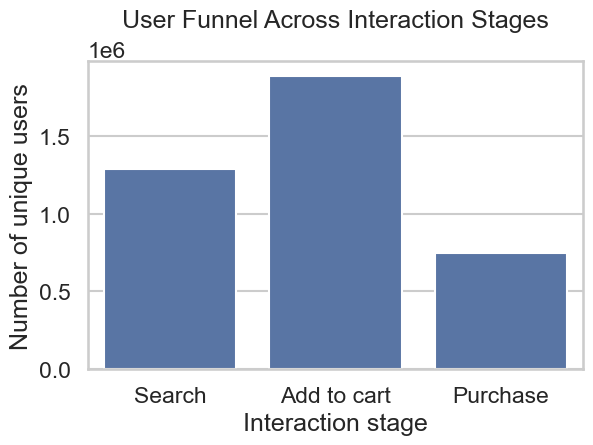

In [16]:
funnel_users = pd.DataFrame({
    "stage": ["Search", "Add to cart", "Purchase"],
    "unique_users": [
        search[USER_COL].nunique(),
        add[USER_COL].nunique(),
        buy[USER_COL].nunique(),
    ],
})

plt.figure()
sns.barplot(
    data=funnel_users,
    x="stage",
    y="unique_users",
)

plt.title("User Funnel Across Interaction Stages")
plt.xlabel("Interaction stage")
plt.ylabel("Number of unique users")

plt.tight_layout()
plt.show()


I compute the number of unique users participating in each funnel stage (search, cart, remove, buy) to quantify behavioral coverage. This complements raw event counts by highlighting how widely each action is represented across the user base. It helps decide which supervision signals are sufficiently dense and whether multi-task objectives are feasible.

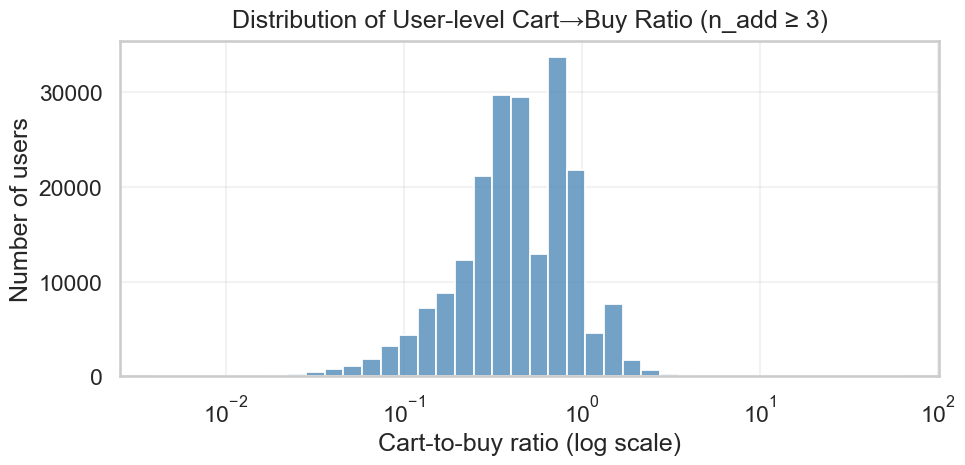

In [ ]:

user_features = pd.DataFrame()

user_features["n_add"] = add.groupby(USER_COL).size()
user_features["n_remove"] = remove.groupby(USER_COL).size()
user_features["n_buy"] = buy.groupby(USER_COL).size()


user_features = user_features.fillna(0).astype(int)

user_features["cart_to_buy"] = (
    user_features["n_buy"] /
    user_features["n_add"].replace(0, np.nan)
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

filtered = user_features[user_features["n_add"] >= 3]

sns.histplot(
    filtered["cart_to_buy"].dropna(),
    bins=40,
    log_scale=(True, False),   # x=log scale, y=linear
    kde=False,
    color="steelblue",
)

plt.title("Distribution of User-level Cart→Buy Ratio (n_add ≥ 3)")
plt.xlabel("Cart-to-buy ratio (log scale)")
plt.ylabel("Number of users")
plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()


I compute per-user ratios (e.g., buys per cart) and visualize their distribution after filtering out very low-activity users to reduce noise. This ratio serves as a behavioral “efficiency” proxy but is not a strict probability: values > 1 can occur if purchases happen without prior cart events or due to logging duplication. The feature is still useful for segmentation and as an input for churn/propensity models.

In [18]:
user_features["cart_to_buy"].describe()

count    1.887989e+06
mean     2.326403e-01
std      5.873254e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.145000e+02
Name: cart_to_buy, dtype: float64

Note on missing values:
For user-level behavioral features (number of searches, cart additions, purchases),
missing values correspond to the absence of a given action and were therefore
interpreted as zero counts. This is a natural assumption for interaction data.


In [ ]:
user_features = pd.DataFrame()

user_features["n_search"] = search.groupby(USER_COL).size()
user_features["n_cart"]   = add.groupby(USER_COL).size()
user_features["n_buy"]    = buy.groupby(USER_COL).size()

user_features = user_features.fillna(0).astype(int)

user_features["search_to_cart"] = user_features["n_cart"] / (user_features["n_search"] + 1)
user_features["cart_to_buy"]    = user_features["n_buy"] / (user_features["n_cart"] + 1)

user_features["buyer_flag"]  = (user_features["n_buy"]  > 0).astype(int)
user_features["cart_flag"]   = (user_features["n_cart"] > 0).astype(int)
user_features["search_flag"] = (user_features["n_search"] > 0).astype(int)

feat_cols = [
    "n_search", "n_cart", "n_buy",
    "search_to_cart", "cart_to_buy",
    "buyer_flag", "cart_flag", "search_flag",
]

X = user_features[feat_cols]


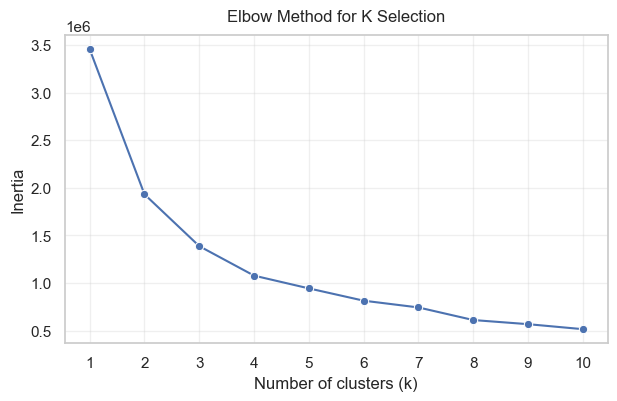

In [20]:
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline

preprocess = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scale", RobustScaler()),
])

X_pp = preprocess.fit_transform(X)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_pp)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
sns.lineplot(x=list(K_range), y=inertias, marker="o")
plt.title("Elbow Method for K Selection")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(alpha=0.3)
plt.show()


In [21]:
k_opt = 2
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_pp)

user_features["cluster"] = clusters


In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample = user_features.sample(30000, random_state=42)

X_pp_sample = preprocess.transform(sample[feat_cols])

X_pca_sample = PCA(n_components=5).fit_transform(X_pp_sample)

X_tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate="auto",
    init="pca",
    random_state=42
).fit_transform(X_pca_sample)


In [26]:
tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "cluster": sample["cluster"].values,
})


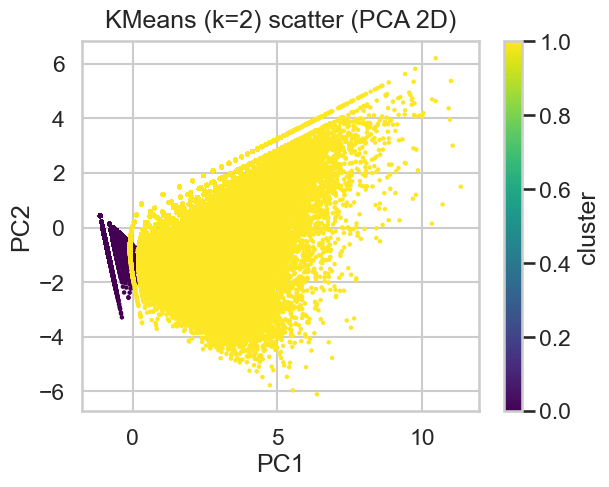

In [ ]:
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2, random_state=42).fit_transform(X_pp)

plt.figure()
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=user_features["cluster"],
    s=3,
    cmap="viridis"   # 换颜色：'tab10', 'plasma', 'coolwarm' 都行
)
plt.title("KMeans (k=2) scatter (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="cluster")
plt.show()


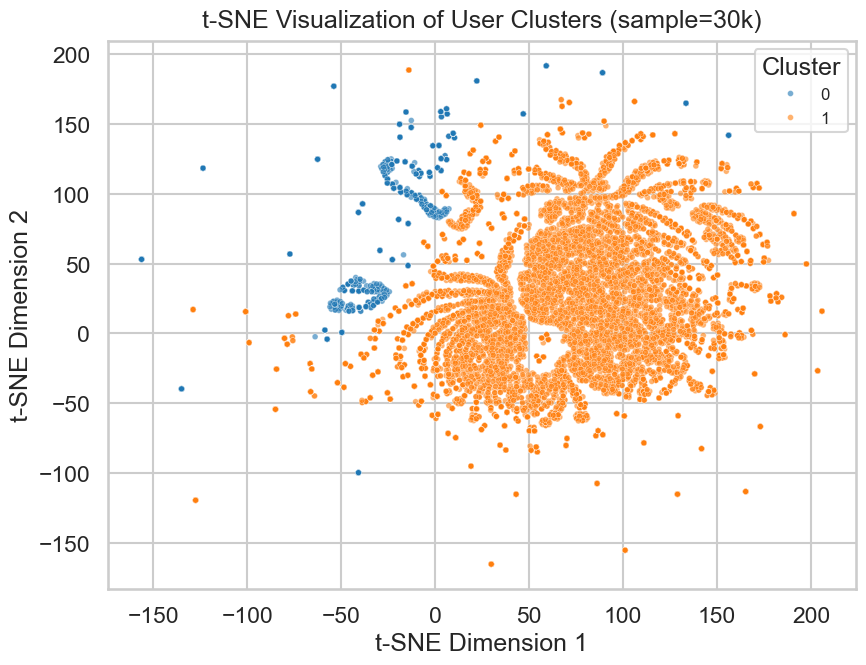

In [ ]:
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(9, 7))

sns.scatterplot(
    data=tsne_df,
    x="tsne_1",
    y="tsne_2",
    hue="cluster",
    palette="tab10",
    alpha=0.6,
    s=18
)

plt.title("t-SNE Visualization of User Clusters (sample=30k)", fontsize=18)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
events = pd.concat([
    search[[USER_COL, TIME_COL]].assign(event="search"),
    add[[USER_COL, TIME_COL]].assign(event="cart"),
    remove[[USER_COL, TIME_COL]].assign(event="remove"),
    buy[[USER_COL, TIME_COL]].assign(event="buy"),
]).sort_values([USER_COL, TIME_COL])


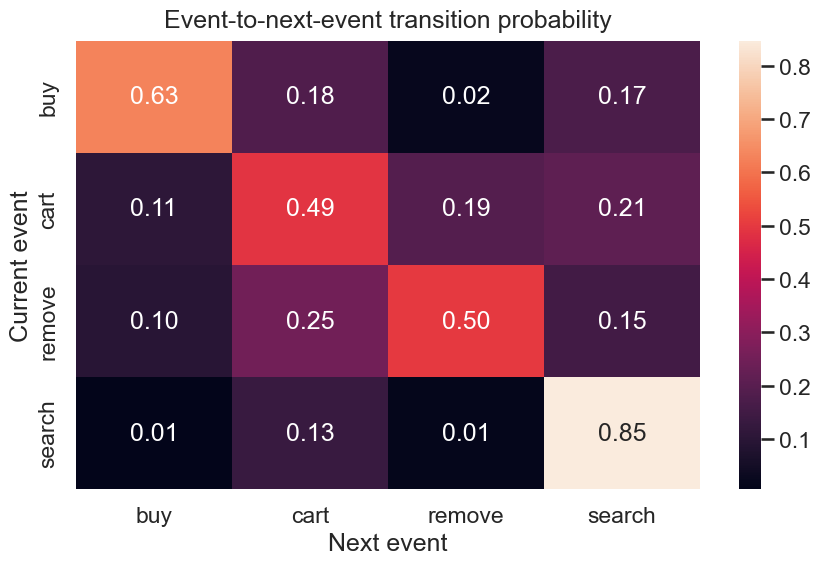

In [ ]:
events2 = events.copy()
events2["next_event"] = events2.groupby(USER_COL)["event"].shift(-1)

trans = pd.crosstab(events2["event"], events2["next_event"], normalize="index")

# plt.figure(figsize=(6,4))
sns.heatmap(trans, annot=True, fmt=".2f")
plt.title("Event-to-next-event transition probability")
plt.xlabel("Next event")
plt.ylabel("Current event")
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

def extract_patterns(df, k=3):
    patterns = []
    for _, g in df.groupby(USER_COL):
        seq = g["event"].tolist()
        for i in range(len(seq) - k + 1):
            patterns.append(tuple(seq[i:i+k]))
    return Counter(patterns)

patterns = extract_patterns(events, k=3)
patterns.most_common(10)


[(('search', 'search', 'search'), 6286894),
 (('cart', 'cart', 'cart'), 1201390),
 (('search', 'search', 'cart'), 807015),
 (('cart', 'search', 'search'), 645256),
 (('remove', 'remove', 'remove'), 497435),
 (('search', 'cart', 'search'), 494864),
 (('cart', 'cart', 'remove'), 485482),
 (('buy', 'buy', 'buy'), 379078),
 (('search', 'cart', 'cart'), 356200),
 (('cart', 'remove', 'remove'), 296420)]

### Summary of EDA Findings

- User and item interactions exhibit strong long-tail distributions.
- Search behavior significantly exceeds transactional events, forming a clear funnel.
- Conversion rates vary widely across users and items, indicating strong heterogeneity.
- User clustering reveals distinct behavioral segments.
- Frequent short interaction sequences suggest applicability of sequence-based and
  pattern mining approaches.
